<h1>Misidentification is Inevitable</h1>

At time of writing (2020-08-17) there are 9 reference distributions for CPU architectures included with Centrifuge: 

 - i386
 - AMD64
 - MIPSEL
 - MIPS64EL
 - ARM64
 - ARMEL
 - PowerPC
 - PPC64
 - SH4
 
ISAdetect will classify code as one of the following 23: 

 - alpha
 - amd64
 - arm64
 - armel
 - armhf
 - hppa
 - i386
 - ia64
 - m68k
 - mips
 - mips64el
 - mipsel
 - powerpc
 - powerpcspe
 - powerpc64
 - powerpc64el
 - riscv
 - s390
 - s390x
 - sh4
 - sparc
 - sparc64
 - x32
 
This is quite a lot, but inevitably incomplete. It is probably not feasible to create a reference distribution or model for every CPU architecture in existence since there are so many. As a result, there are some architectures not listed here that may be encountered when analyzing firmware binaries from "out in the wild". These include:

 - AVR
 - Xtensa
 - Ubicom
 - ARM-Thumb
 
For these architectures, finding enough samples to study in a rigorous way is not so easy. However, enough devices use these CPUs that if one analyzes enough firmware, it is likely that an image targeting at least one of these architectures will be encountered. It is therefore important to be able to see what happens when Centrifuge and/or ISAdetect are used to analyze a file containing machine code that targets one of these architectures, because the machine code will either **a) not identified as code or b) be misclassified/misidentified as targeting some other architecture**. Obviously this is an issue if the goal is to correctly disassemble and/or decompile the code.

<h1>Example 1: Arduino's wifiHD_2_1.elf</h1>
    
Download link: https://github.com/arduino/ArduinoCore-avr/raw/master/firmwares/wifishield/binary/wifiHD_2_1.elf


Using `readelf` to examing the ELF header, we see that the architecture is listed as "unknown":

```
$ readelf -h wifiHD_2_1.elf 
ELF Header:
  Magic:   7f 45 4c 46 01 02 01 00 00 00 00 00 00 00 00 00 
  Class:                             ELF32
  Data:                              2's complement, big endian
  Version:                           1 (current)
  OS/ABI:                            UNIX - System V
  ABI Version:                       0
  Type:                              EXEC (Executable file)
  Machine:                           <unknown>: 0x18ad             <---------------------
  Version:                           0x1
  Entry point address:               0x80000000
  Start of program headers:          52 (bytes into file)
  Start of section headers:          1240644 (bytes into file)
  Flags:                             0x0
  Size of this header:               52 (bytes)
  Size of program headers:           32 (bytes)
  Number of program headers:         5
  Size of section headers:           40 (bytes)
  Number of section headers:         26
  Section header string table index: 23
```

Even so, we can be confident that this is an AVR executable because we know going in what kind of hardware this binary is intended to run on.

Although located in a subdirectory of "firmwares" in the Arduino AVR core repository, this is actually an ELF binary. This means it is possible to identify exactly where in the file the machine code is located by parsing the section header table with `readelf` or equivalent:

```
$ readelf -SW wifiHD_2_1.elf 
There are 26 section headers, starting at offset 0x12ee44:

Section Headers:
  [Nr] Name              Type            Addr     Off    Size   ES Flg Lk Inf Al
...
  [ 3] .text             PROGBITS        80002008 002408 030564 00  AX  0   0  4
...
```

We can highlight this region prior to clustering with DBSCAN to make identifying the cluster containing machine code as easy as possible:

In [1]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]  

sys.path[0:0] = ['.', '..']

from centrifuge.binfile import BinFile

In [2]:
file_handle = open("wifiHD_2_1.elf", "rb")
AVR_bin = BinFile(file_handle)
AVR_bin.slice_file()

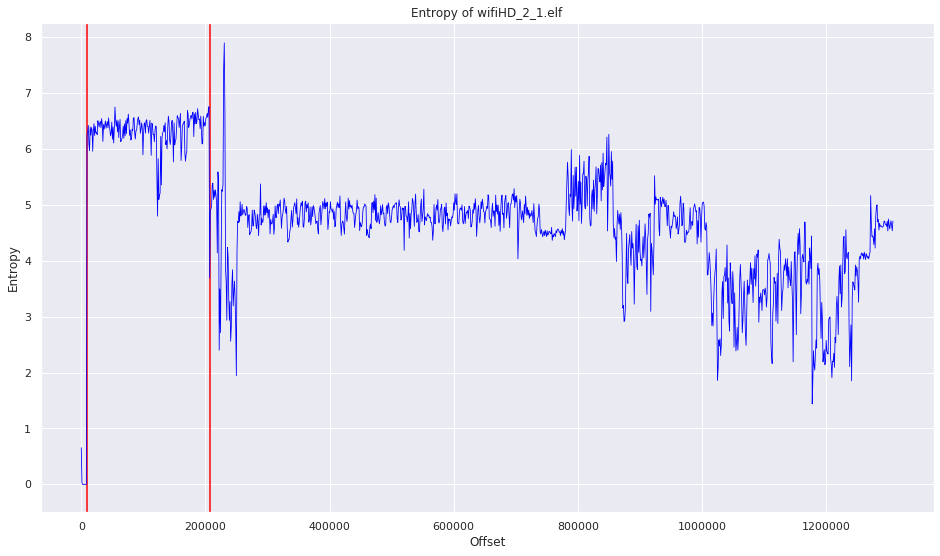

In [3]:
AVR_bin.plot_file_entropy(0x002408, 0x002408 + 0x030564)

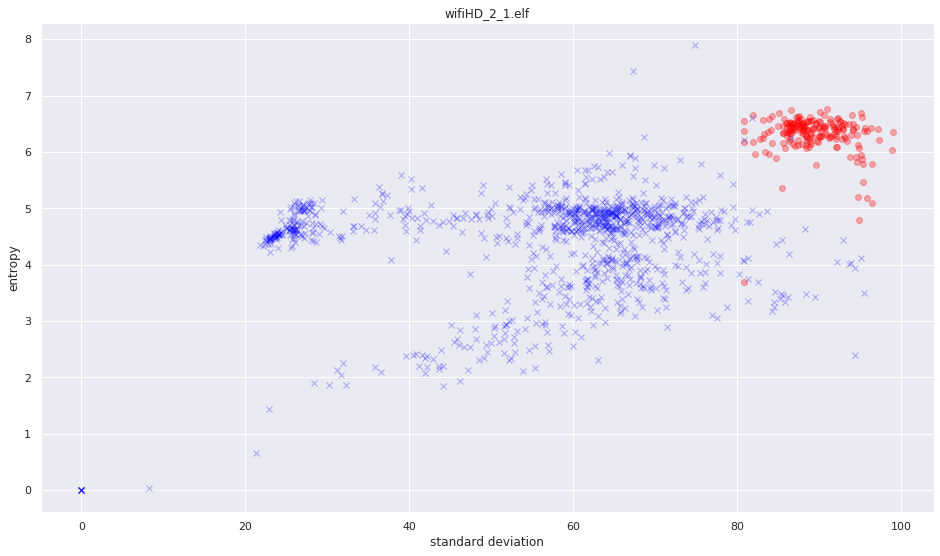

In [4]:
AVR_bin.plot_variables_by_range(AVR_bin.block_byteval_std_dev,
                                AVR_bin.block_entropy_levels,
                                0x002408,
                                0x002408 + 0x030564,
                                "o",
                                "x",
                                "red",
                                "blue",
                                "wifiHD_2_1.elf",
                                "standard deviation",
                                "entropy")

Ok so the `.text` section which contains the file's machine code is easily distinguishable here. On to clustering.

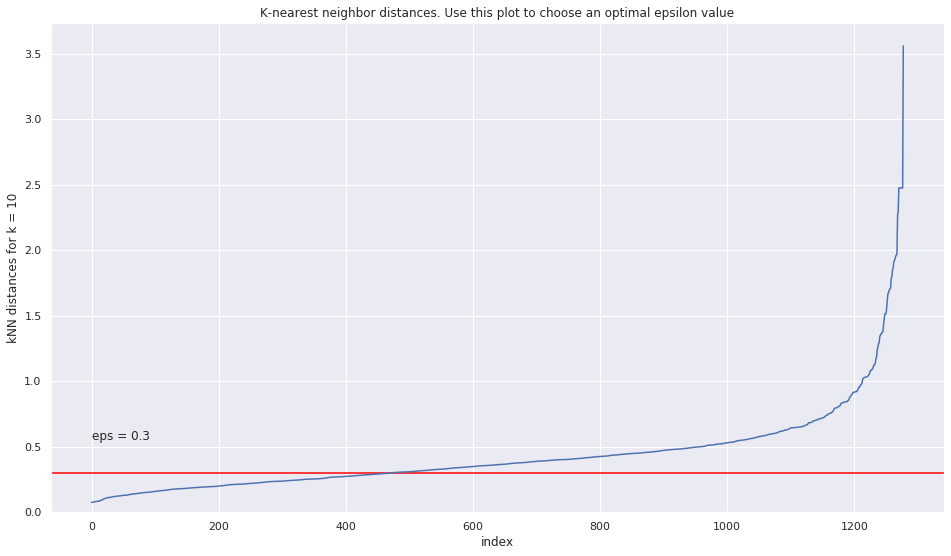

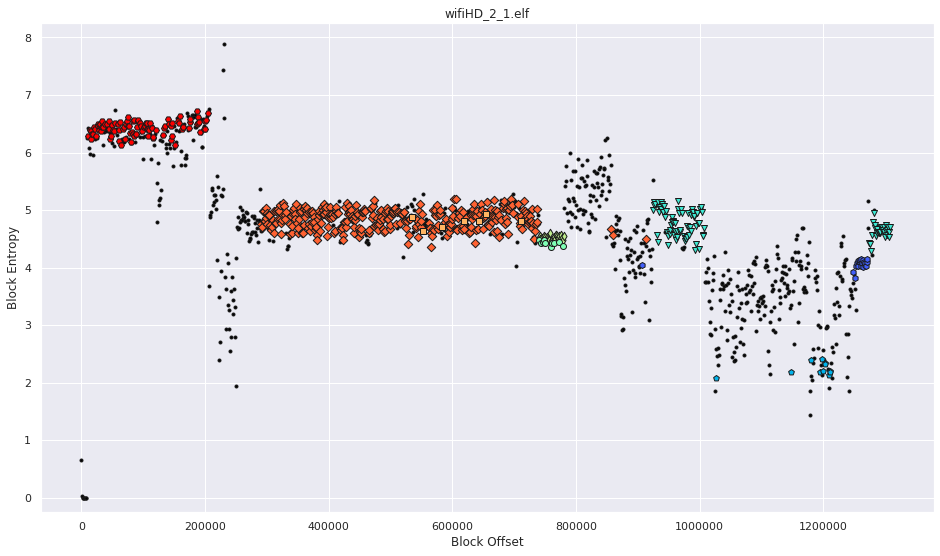

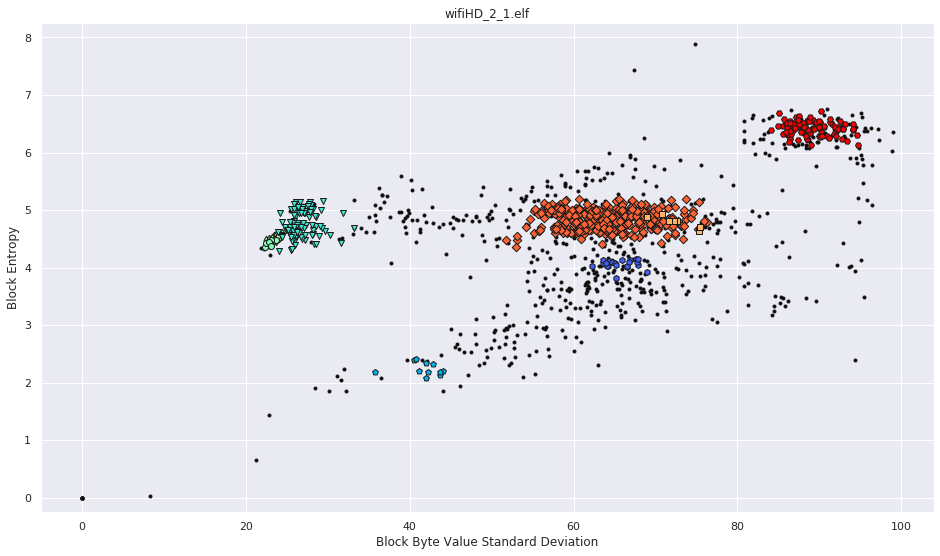

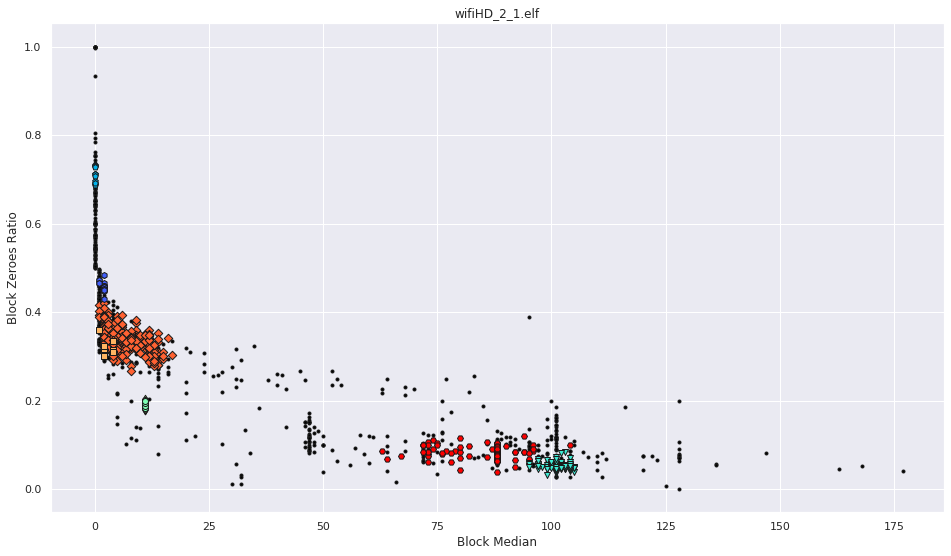

In [5]:
AVR_bin.cluster_DBSCAN(epsilon=0.3,
                       minimum_samples=10,
                       find_optimal_epsilon=True)
AVR_bin.plot_DBSCAN_results()

The cluster consisting of red circles is machine code. We know this without having to use any other tools. As stated previously, we can be confident that this code targets an AVR CPU. However, ISAdetect does not support AVR, so we get a misclassification:

In [6]:
results = AVR_bin.identify_cluster_data_types()

Searching for machine code
--------------------------------------------------------------------

[+] Checking Cluster 0 for possible match
[+] Closely matching CPU architecture reference(s) found for Cluster 0
[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "armhf",
        "endianness": "little",
        "wordsize": 32
    },
    "prediction_probability": 0.21
}


Searching for utf8-english data
-------------------------------------------------------------------

[+] UTF-8 (english) detected in Cluster 5
    Wasserstein distance to reference: 13.034103917107021


Searching for high entropy data
-------------------------------------------------------------------

[X] No high entropy data cluster detected.



ISAdetect tells us the target architecture of this code is ARMHF, but the prediction probility (a kind of confidence measure) is very low, only 0.21. For context, this is approximately the same probability returned by ISAdetect when it analyzes a PNG image file and predicts it is code targeting the m6800 architecture.

When we look at the results returned by `identify_cluster_data_types()`, we can also see that the distribution of the AVR code in the file is similar to no less than 5 different architectures, ARM64 having the smallest Wasserstein distance of ~5.71.

In [7]:
results["machine code"][0]["Cluster 0"]

[7.044486906925155,
 {'MIPS64EL_reference': 19.047786698232322,
  'PowerPC_reference': 19.281198606613007,
  'i386_reference': 7.86663914291351,
  'ARMEL_reference': 13.877032390861745,
  'MIPSEL_reference': 30.03267696717172,
  'PPC64_reference': 7.623866405224118,
  'AMD64_reference': 7.272337096117423,
  'ARM64_reference': 5.707213517597855,
  'SH4_reference': 7.781727457859848}]

In order to distinguish AVR from code targeting these other architectures using machine learning, we need enough AVR code such that a classification algorithm trained on it reaches a suitable level of accuracy. There is roughly 200000 Kb of AVR code just in the file being analyzed here, wifiHD_2_1.elf, but is likely insufficient. Ideally, we would want at least a few megabytes in total, extracted from several different files.

In [8]:
file_handle.close()

<h1>Example 2: Flanders Scientific's FW_CM170_1.1.04_2249_FSI.img</h1>

The example above involved misidentification of AVR code by ISAdetect. Another possibility when analyzing a file containing code targeting an architecture for which there is no is reference distribution is that the code is not identified as such. This happens when none of the Wasserstein distances between the distribution of the code in the file and all the CPU architecture reference distributions are less than 10 (a cutoff chosen by me based on experience). In such a case, the code will not be analyzed by ISAdetect since it is not deemed to be a close match to any CPU architecture reference distribution.

Download link: https://www.flandersscientific.com/firmware/11042249/FW_CM170_1.1.04_2249_FSI.img.zip

After unzipping and running a signature scan with Binwalk, we see the following output:

```
$ binwalk FW_CM170_1.1.04_2249_FSI.img

DECIMAL       HEXADECIMAL     DESCRIPTION
--------------------------------------------------------------------------------
2880505       0x2BF3F9        Copyright string: "Copyright MGC 2004 - Nucleus PLUS - T1040/50 Xtensa v. 1.14"
3313563       0x328F9B        Intel x86 or x64 microcode, sig 0x00000040, pf_mask 0x00, 2000-02-10, rev 0x410000, size 2048
3590124       0x36C7EC        LZMA compressed data, properties: 0xC0, dictionary size: 0 bytes, uncompressed size: 256 bytes
3661155       0x37DD63        LZMA compressed data, properties: 0xC0, dictionary size: 0 bytes, uncompressed size: 32 bytes
4865616       0x4A3E50        LZMA compressed data, properties: 0x7E, dictionary size: 0 bytes, uncompressed size: 60 bytes
```

Right away there is a problem, because the first signature match is for a copyright string referring to Xtensa, but the second signature match is for x86/x64 microcode. It is unlikely that the binary contains both Xtensa code and x86 microcode, so which signature is correct? In fact, it is well within the realm of possibility that both of these signature matches are red herrings. Centrifuge can be used to further investigate the binary.

In [9]:
file_handle = open("FW_CM170_1.1.04_2249_FSI.img", "rb")
flanders = BinFile(file_handle)
flanders.slice_file()

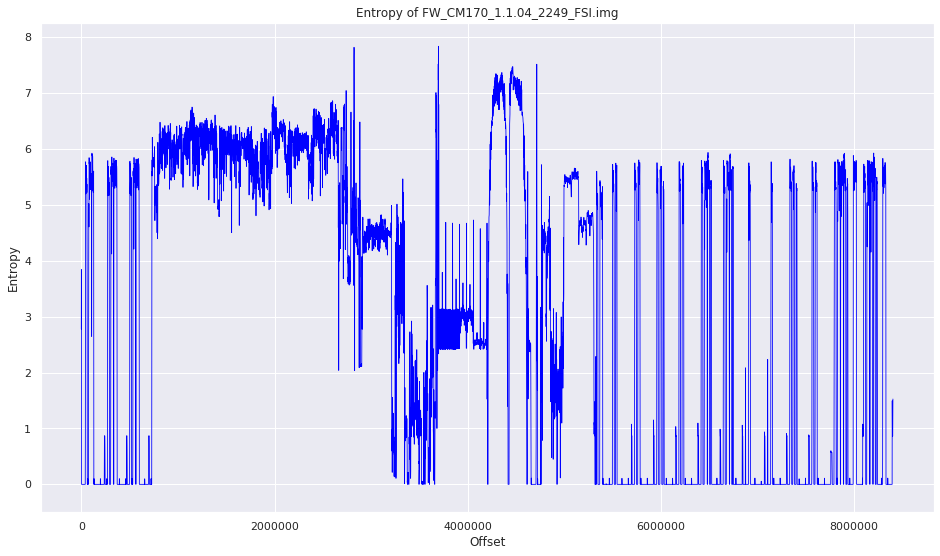

In [10]:
flanders.plot_file_entropy()

We can check to see if clusters form by examining a scatterplot and highlighting the region between offsets 750000 and 2650000, which is the area towards the beginning of the file that has an average entropy level of around 6.

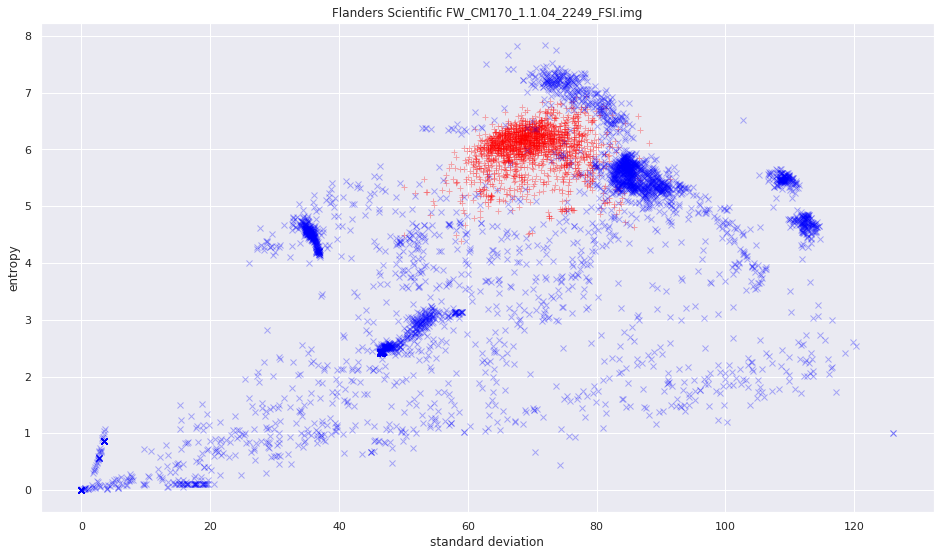

In [11]:
flanders.plot_variables_by_range(flanders.block_byteval_std_dev,         # 1st variable
                                 flanders.block_entropy_levels,          # 2nd variable
                                 750000,                                    # start file offset
                                 2650000,                                   # end file offset
                                 target_data_marker='+',                    # marker shape for points that fall within the specified offsets
                                 other_data_marker='x',                     # marker for points outside of offsets
                                 target_data_color='red',                   # color of points inside offsets
                                 other_data_color='blue',                   # color of points outside offsets
                                 title='Flanders Scientific FW_CM170_1.1.04_2249_FSI.img',   
                                 xlabel='standard deviation',
                                 ylabel='entropy')

Several clearly-defined clusters form, as usual. Cluster analysis time.

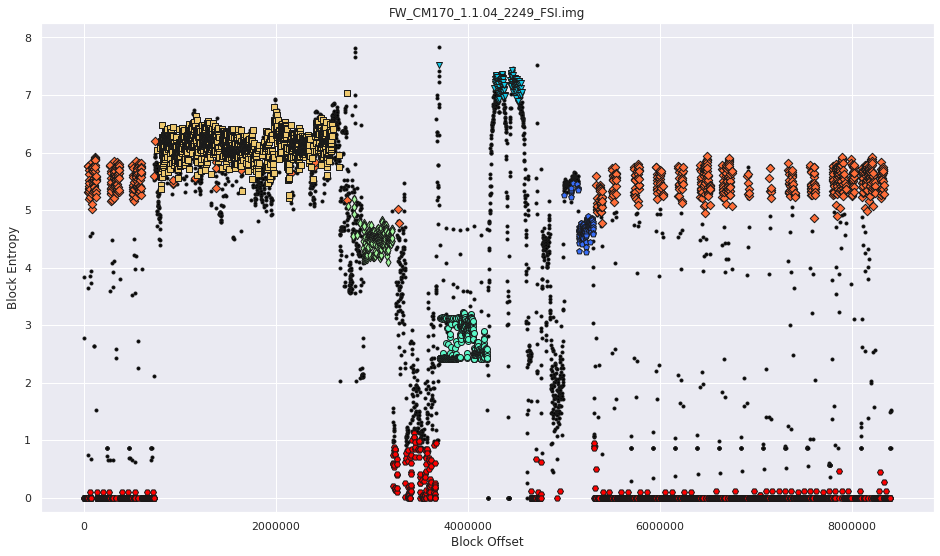

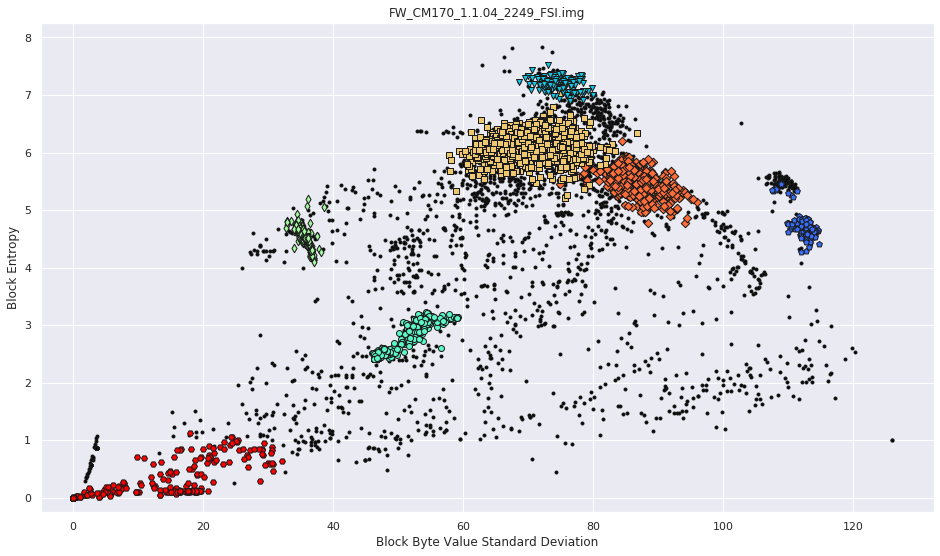

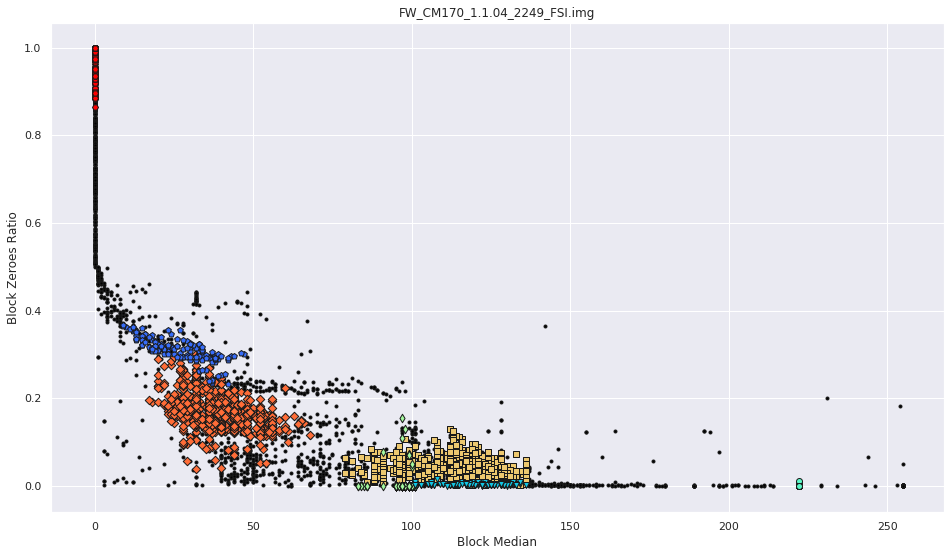

In [12]:
flanders.cluster_DBSCAN(0.3, 100, False)
flanders.plot_DBSCAN_results()

The clusters look fairly cohesive, so we can move on to data type identification.

In [13]:
results = flanders.identify_cluster_data_types()

Searching for machine code
--------------------------------------------------------------------

[+] Checking Cluster 1 for possible match
[X] No closely matching CPU architecture reference found.


[+] Checking Cluster 2 for possible match
[X] No closely matching CPU architecture reference found.


[X] No machine code cluster detected



Searching for utf8-english data
-------------------------------------------------------------------

[+] UTF-8 (english) detected in Cluster 3
    Wasserstein distance to reference: 17.909008513289038


Searching for high entropy data
-------------------------------------------------------------------

[+] High entropy data found in Cluster 5
    Wasserstein distance to reference: 6.58909435096154
[*] This distance suggests the data in this cluster is compressed



In the output above, analysis of the data in clusters 1 and 2 results in the message "[X] No closely matching CPU architecture reference found." In this case it is useful to look at all of the Wasserstein distances measured between clusters 1 and 2 and the CPU architecture reference distributions:

In [14]:
results["machine code"][0]["Cluster 1"]

[25.663765238472752,
 {'MIPS64EL_reference': 14.03841305589246,
  'PowerPC_reference': 22.994100830929998,
  'i386_reference': 34.575702928393646,
  'ARMEL_reference': 41.65016905884562,
  'MIPSEL_reference': 13.846799806554202,
  'PPC64_reference': 25.64288719320876,
  'AMD64_reference': 30.877768888827433,
  'ARM64_reference': 29.243591100703224,
  'SH4_reference': 28.69622488116309}]

In [15]:
results["machine code"][0]["Cluster 2"]

[19.708092875987962,
 {'MIPS64EL_reference': 27.573066652463645,
  'PowerPC_reference': 16.671734467184972,
  'i386_reference': 18.04963907616872,
  'ARMEL_reference': 28.385357076938615,
  'MIPSEL_reference': 26.11164609860914,
  'PPC64_reference': 21.990110118134094,
  'AMD64_reference': 19.057802317857682,
  'ARM64_reference': 21.885873463550077,
  'SH4_reference': 18.76270465588399}]

The smallest distance for cluster 1 is ~13.85 between it and the MIPSEL reference, whereas for cluster 2 it is 16.67 between it and PowerPC. Judging just by minimum distances, it might appear that they both may contain machine code, just for an architecture for which there is no reference here. However, when we actually look at plots of the distributions of these two clusters, it becomes apparent that cluster 1 does not contain machine code but cluster 2 does:

In [16]:
_, cluster_byte_values = flanders.extract_clusters()

cluster_1 = cluster_byte_values[1]
cluster_2 = cluster_byte_values[2]

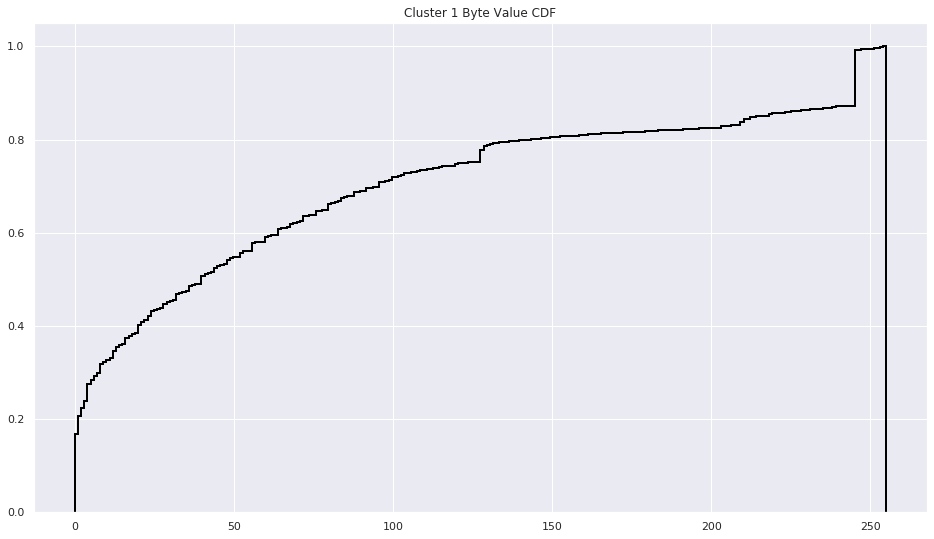

In [17]:
sns.distplot(cluster_1, 
             bins=256, 
             kde=False, 
             norm_hist=True, 
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':1}, 
             kde_kws={'cumulative': True},
             color="black")
plt.title("Cluster 1 Byte Value CDF")
plt.show()

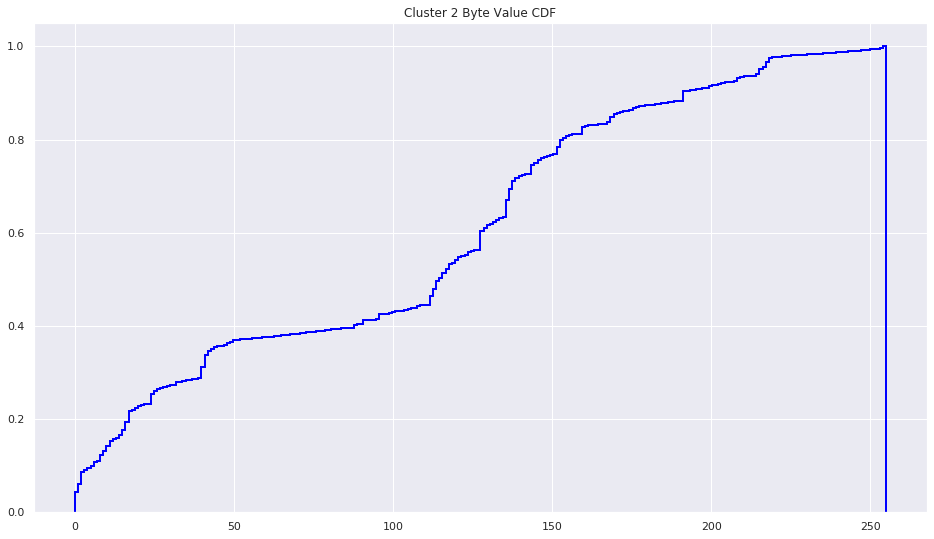

In [18]:
sns.distplot(cluster_2, 
             bins=256, 
             kde=False, 
             norm_hist=True, 
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':1}, 
             kde_kws={'cumulative': True},
             color="blue")
plt.title("Cluster 2 Byte Value CDF")
plt.show()

Let us compare these histograms with histograms of the CPU architecture reference distributions:

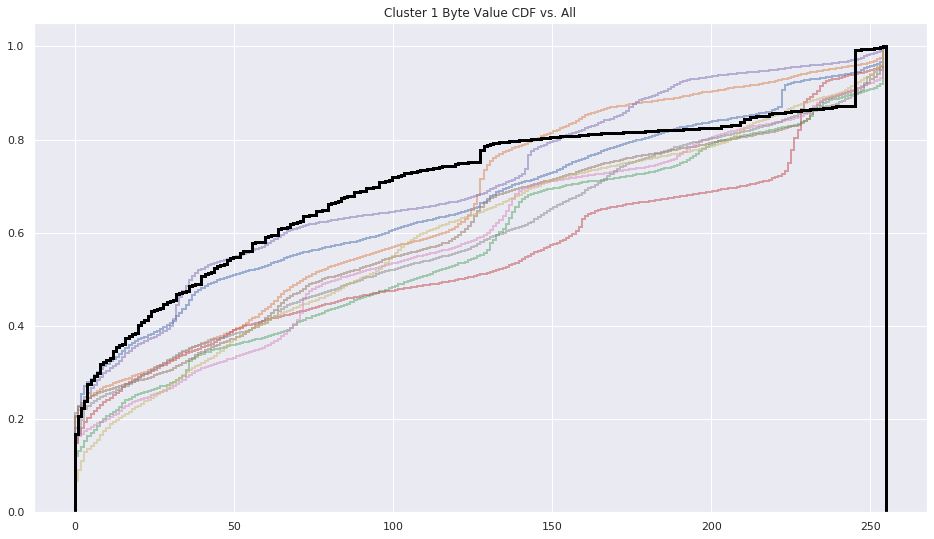

In [19]:
arch_refs = flanders.load_machine_code_distributions()
for arch, byte_values in arch_refs.items():
    sns.distplot(byte_values, 
                 bins=256, 
                 kde=False, 
                 norm_hist=True, 
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':0.5}, 
                 kde_kws={'cumulative': True})
    #plt.title(arch + " Byte Value CDF")
    
sns.distplot(cluster_1, 
             bins=256, 
             kde=False, 
             norm_hist=True, 
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':3, 'alpha':1}, 
             kde_kws={'cumulative': True},
             color="black")
plt.title("Cluster 1 Byte Value CDF vs. All")
plt.show()

We can see right away that the CDF is nearly flat for values between ~130 and ~245, and then jumps sharply afterward. This contrasts sharply with the CPU architecture reference distribution CDFs.

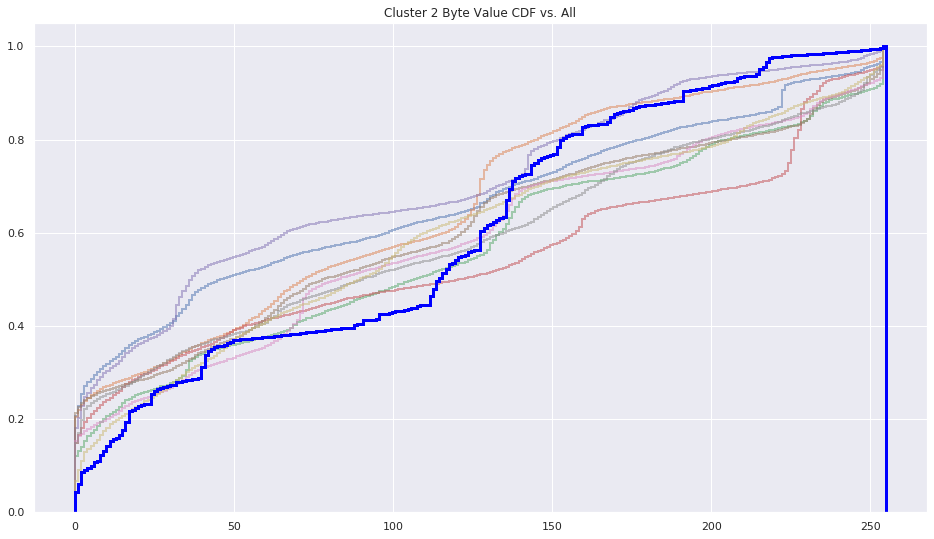

In [20]:
arch_refs = flanders.load_machine_code_distributions()
for arch, byte_values in arch_refs.items():
    sns.distplot(byte_values, 
                 bins=256, 
                 kde=False, 
                 norm_hist=True, 
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':0.5}, 
                 kde_kws={'cumulative': True})
    #plt.title(arch + " Byte Value CDF")
    
sns.distplot(cluster_2, 
             bins=256, 
             kde=False, 
             norm_hist=True, 
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':3, 'alpha':1}, 
             kde_kws={'cumulative': True},
             color="blue")
plt.title("Cluster 2 Byte Value CDF vs. All")
plt.show()

Based on these plots, we can see that compared with the reference distributions, the shape of the CDF of cluster 1 looks quite strange. It may not be that far off from some of them in terms of overall distance, but the distribution of byte values between ~70 and 255 is unlike that of any of the references, and significantly so.

In contrast with this, the shape of cluster 2's CDF is much more in line with the reference distributions. However, no conclusions can be drawn at this point whether cluster 1 or cluster 2 contain machine code. As before, more data is required. At this point, my best guess is that cluster 1 does not contain machine code but cluster 2 does.

We can send these clusters to ISAdetect to verify that neither cluster 1 or cluster 2 match any of the 23 architectures used to create its models:

In [21]:
_ = flanders.get_arch_ID(cluster_1)

[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "hppa",
        "endianness": "big",
        "wordsize": 32
    },
    "prediction_probability": 0.15
}



In [22]:
_ = flanders.get_arch_ID(cluster_2)

[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "i386",
        "endianness": "little",
        "wordsize": 32
    },
    "prediction_probability": 0.12
}



Very low probabilities for both classifications.

In this case, the next step would be to collect executable binaries known to target the Xtensa instruction set architecture in order to determine whether cluster 2 does in fact contain Xtensa machine code as the copyright string found by Binwalk alludes to. This is left as an exercise to the reader.

In [23]:
file_handle.close()